In [30]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
import cv2
import pandas as pd
import random
import os
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import imgaug.augmenters as iaa

In [31]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

In [32]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(df)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    image_path.append(os.path.join(datadir, left.strip()))
    steering.append(float(indexed_data[3]) + 0.15)
    image_path.append(os.path.join(datadir, right.strip()))
    steering.append(float(indexed_data[3]) - 0.15)
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

In [33]:
def img_preprocess(img):
    img = mpimg.imread(img)
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img / 255.0  # Normalize

    return img

In [34]:
def preprocessed_ima_no_imread(img):
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img / 255.0  # Normalize

    return img

In [35]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  model.add(Dense(50, activation = 'elu'))
  model.add(Dense(10, activation = 'elu'))
  model.add(Dense(1))

  optimizer = Adam(learning_rate = 0.0001)
  model.compile(loss='mse', optimizer = optimizer)
  return model

In [36]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

In [37]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

In [38]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

In [39]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle 

In [40]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)

  return image, steering_angle

In [41]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths)-1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = preprocessed_ima_no_imread(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

<bound method NDFrame.head of                                                   center  \
0      C:\Users\kevin\Desktop\DriveTest\IMG\center_20...   
1      C:\Users\kevin\Desktop\DriveTest\IMG\center_20...   
2      C:\Users\kevin\Desktop\DriveTest\IMG\center_20...   
3      C:\Users\kevin\Desktop\DriveTest\IMG\center_20...   
4      C:\Users\kevin\Desktop\DriveTest\IMG\center_20...   
...                                                  ...   
24168  C:\Users\kevin\SmartTech CA2\DriveTests\IMG\ce...   
24169  C:\Users\kevin\SmartTech CA2\DriveTests\IMG\ce...   
24170  C:\Users\kevin\SmartTech CA2\DriveTests\IMG\ce...   
24171  C:\Users\kevin\SmartTech CA2\DriveTests\IMG\ce...   
24172  C:\Users\kevin\SmartTech CA2\DriveTests\IMG\ce...   

                                                    left  \
0      C:\Users\kevin\Desktop\DriveTest\IMG\left_2024...   
1      C:\Users\kevin\Desktop\DriveTest\IMG\left_2024...   
2      C:\Users\kevin\Desktop\DriveTest\IMG\left_2024...   
3      C:

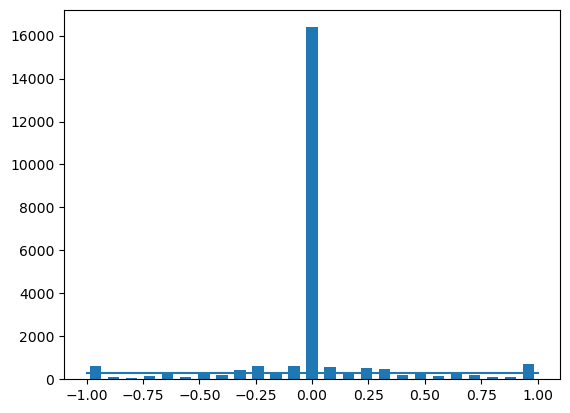

Total Data 24173

When looking at the total number of images, we can see that is too many 0 steering angles in the dataset. This is because the car is driving straight most of the time.
To fix this, we will remove some of the images with 0 steering angles. As if we were to leave them all in the model would mainly be learning from those 0s and not learning
how to steer when needed. We will removing around 75 percent of the 0 steering angle images. This will leave us with a more balanced dataset.

removed 18335
remaining 5838


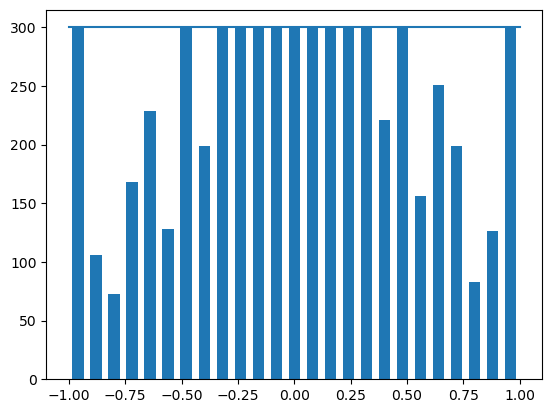

Training Samples: 14011
Valid Samples: 3503


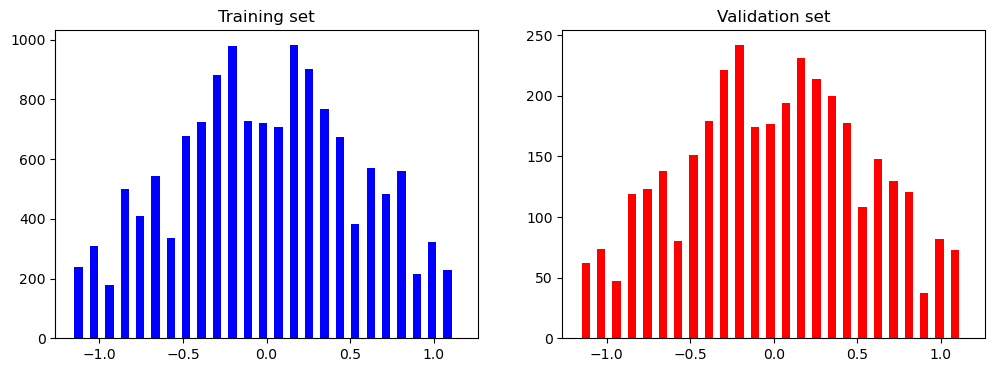

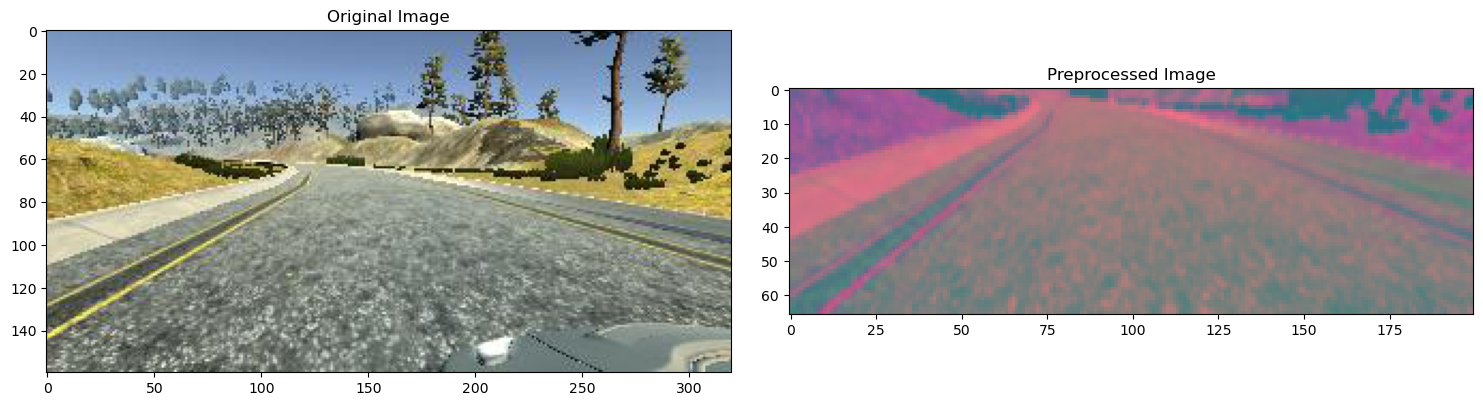

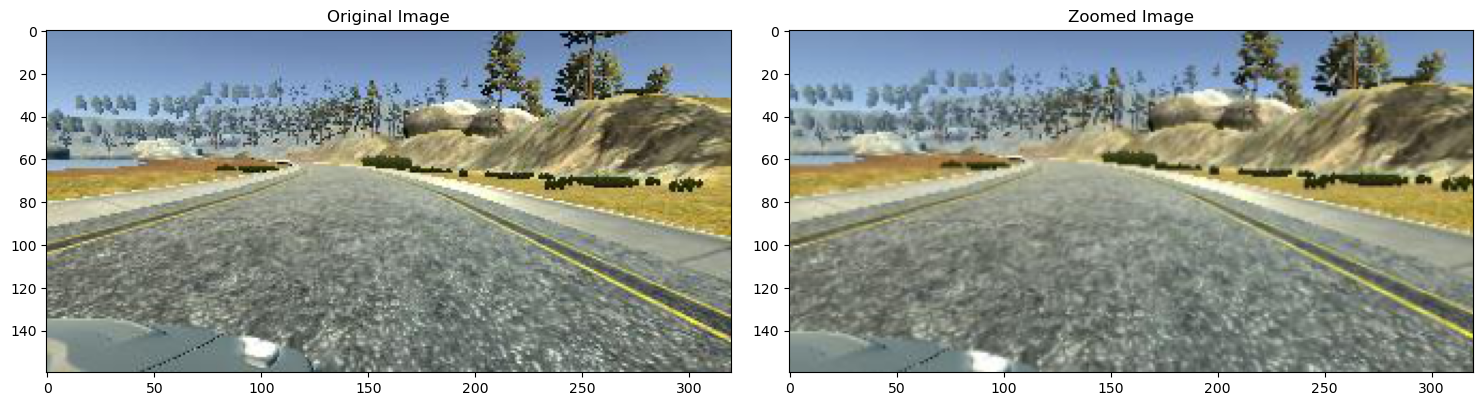

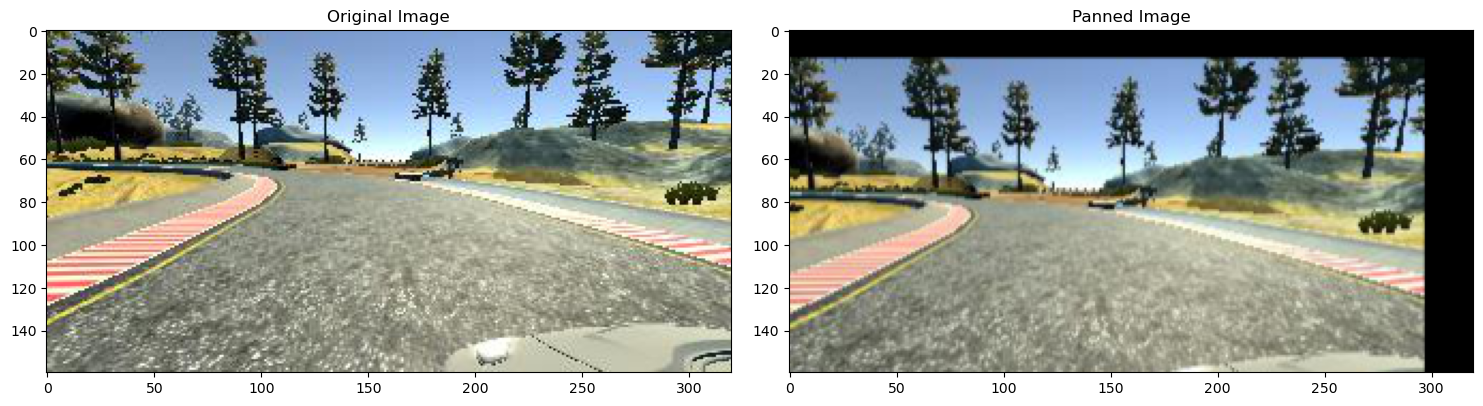

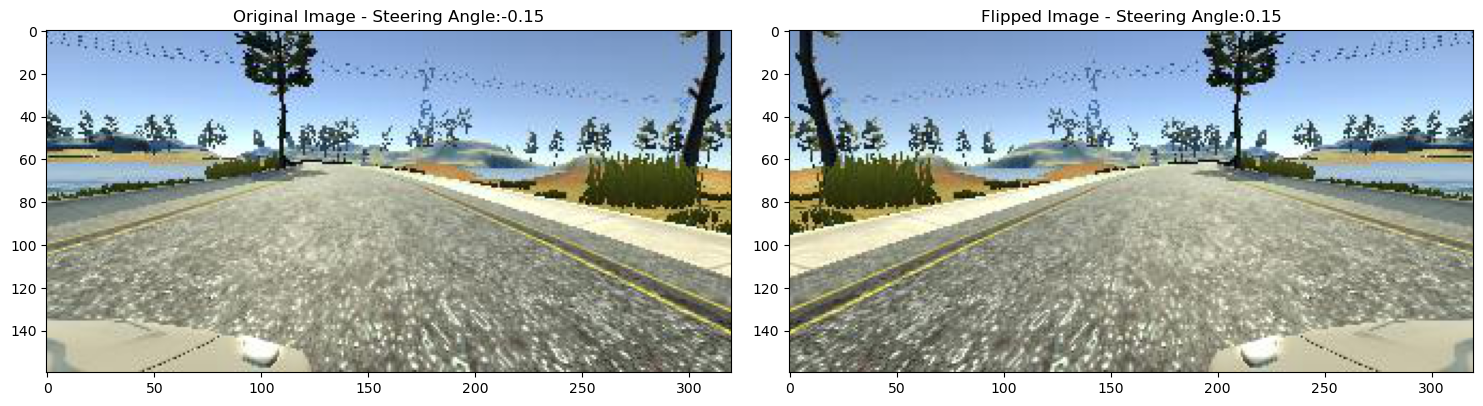

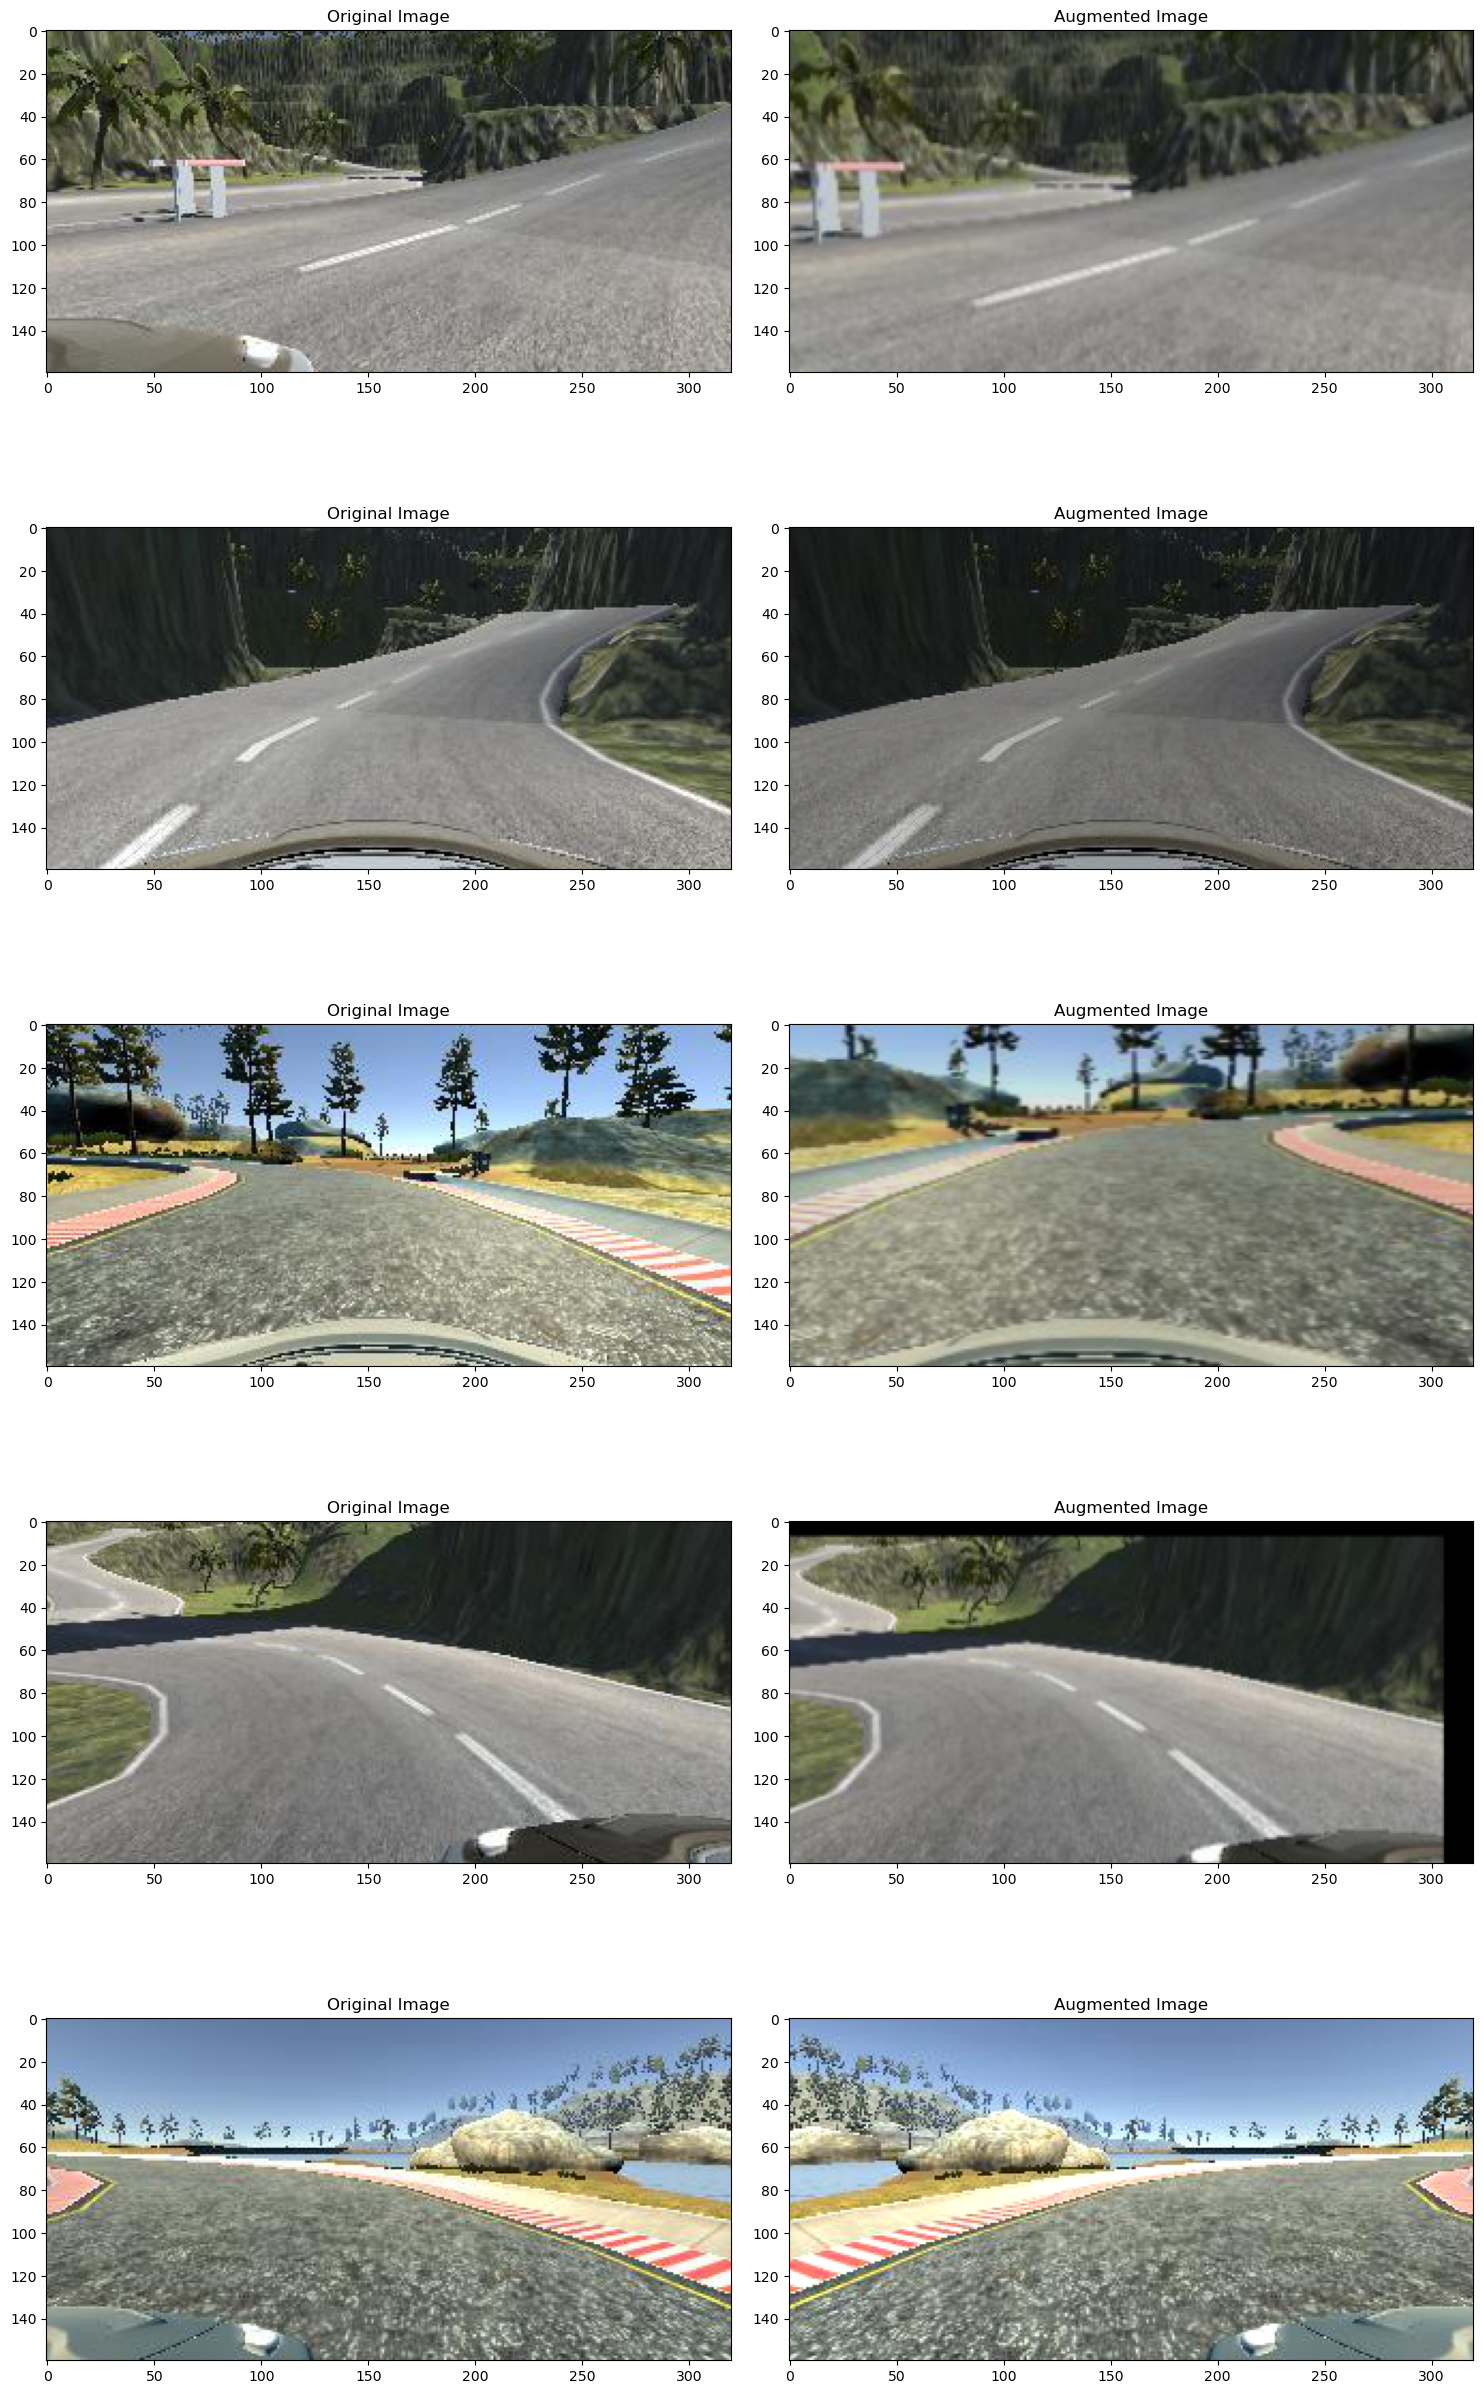

In [42]:
datadir = "DriveTests"
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
print(data.head)

data['center'] = data['center'].apply(lambda x: path_leaf(x) if pd.notna(x) else x)
data['left'] = data['left'].apply(lambda x: path_leaf(x) if pd.notna(x) else x)
data['right'] = data['right'].apply(lambda x: path_leaf(x) if pd.notna(x) else x)


num_bins = 25
hist, bins = np.histogram(data['steering'], num_bins)
print(bins)
centre = (bins[:-1] + bins[1:])*0.5
samples_per_bin = 300
plt.bar(centre, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
plt.show()

remove_list = []
print('Total Data', len(data))

for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if bins[j] <= data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('')
print('When looking at the total number of images, we can see that is too many 0 steering angles in the dataset. This is because the car is driving straight most of the time.')
print('To fix this, we will remove some of the images with 0 steering angles. As if we were to leave them all in the model would mainly be learning from those 0s and not learning')
print('how to steer when needed. We will removing around 75 percent of the 0 steering angle images. This will leave us with a more balanced dataset.')
print('')
print('removed', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining', len(data))

hist, bins = np.histogram(data['steering'], (num_bins))
plt.bar(centre, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
plt.show()

image_paths, steerings = load_img_steering(datadir + '/IMG', data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')
plt.show()

image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')
plt.show()

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(zoomed_image)
axes[1].set_title('Zoomed Image')
plt.show()

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(panned_image)
axes[1].set_title('Panned Image')
plt.show()

random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
axes[1].imshow(flipped_image)
axes[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))
plt.show()

ncol = 2
nrow = 5
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 25))
fig.tight_layout()
for i in range(5):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]
    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)
    axes[i][0].imshow(original_image)
    axes[i][0].set_title("Original Image")
    axes[i][1].imshow(augmented_image)
    axes[i][1].set_title("Augmented Image")
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 dense_4 (Dense)             (None, 100)              

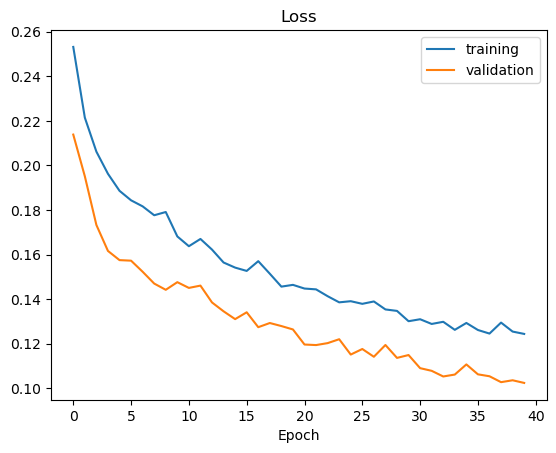

c:\Users\kevin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [43]:
model = nvidia_model()
print(model.summary())

history = model.fit(batch_generator(X_train, y_train, 200, 1), steps_per_epoch=120,
                     epochs=40, validation_data=batch_generator(X_valid, y_valid, 200, 0),
                     validation_steps=200, verbose=1, shuffle = 1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

model.save('Delta_model.h5')
